In [6]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
from pprint import pprint

BATCH_SIZE = 2
IMAGE_SIZE = (256, 384)
BBOX_FORMAT = "xywh"

class_map = {
    0: "box",
    1: "green_light",
    2: "left_arrow",
    3: "no_light",
    4: "person",
    5: "red_light",
    6: "right_arrow",
    7: "tree",
    8: "unknown_arrow",
}

In [7]:
validation_resizing = keras_cv.layers.Resizing(
    height=IMAGE_SIZE[0],
    width=IMAGE_SIZE[1],
    bounding_box_format=BBOX_FORMAT,
    pad_to_aspect_ratio=True,
)

In [8]:
model = keras.models.load_model(
    "object_detection/mobilenetv3-large_1714324850.keras",
    custom_objects={"YOLOV8Detector": keras_cv.models.YOLOV8Detector},
)

In [9]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.5,  # Minimum IOU for two boxes to be considered the same
    confidence_threshold=0.501,  # Minimum confidence for a box to be considered a detection
    max_detections=8,  # Maximum number of detections to keep
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'boxes': array([[[ 98.93739 ,  32.334747,  35.54895 ,  63.672615],
        [ 56.725304,  32.721947,  28.473106,  58.987732],
        [150.0945  ,  49.271584,  27.810349,  51.82702 ],
        [224.9188  ,  50.566704,  37.3479  ,  57.666893],
        [196.75955 ,  77.56553 ,  22.131424,  22.69838 ],
        [192.62282 ,  68.66924 ,  17.407333,  33.277016],
        [228.90141 ,  60.84721 ,  22.148499,  47.62734 ],
        [ 61.963287,  52.985622,  19.316292,  38.73064 ]]], dtype=float32),
 'classes': ['right_arrow',
             'right_arrow',
             'right_arrow',
             'right_arrow',
             'tree',
             'tree',
             'tree',
             'right_arrow'],
 'confidence': array([[0.5039293 , 0.5018101 , 0.5015566 , 0.5014428 , 0.50140864,
        0.5014052 , 0.50129795, 0.5012544 ]], dtype=float32),
 'num_detections': array([8], dtype=int32)}


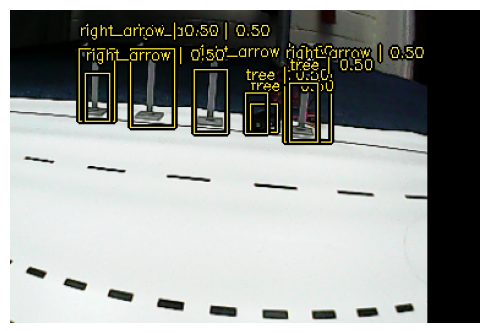

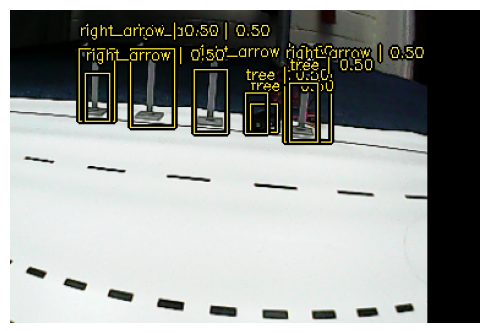

In [10]:
image = tf.io.read_file("label_data/label_kaggle_test/images/0e505958-404.png")
image = tf.image.decode_png(image, channels=3)
image = tf.cast(image, tf.float32)
image = np.array(image)
image = validation_resizing([image])


y_pred = model.predict(image)
y_pred_print = y_pred.copy()
y_pred_print["classes"] = [class_map[i] for i in y_pred["classes"].flatten() if i != -1]
pprint(y_pred_print)
"""Format:
{'boxes': [[x_left, y_top, width, height], ...],
 'classes': [class_id, ...],
 'confidence': [confidence, ...]
 'num_detections': [int]}
"""

keras_cv.visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.4,
    line_thickness=1,
    bounding_box_format=BBOX_FORMAT,
    class_mapping=class_map,
)